# Dinamic stochastic models in Python

## Forecasting non-observables

1. Load libraries

In [5]:
import sys
sys.path.append('Libraries')
import DSGE_LinearMethods as DLM
import DSGE_PreProcessing as DPP
import HandleTimeSeries as HTS
import sympy as sp
sp.init_session(use_latex=True)

IPython console for SymPy 1.12 (Python 3.12.4-64-bit) (ground types: python)

These commands were executed:
>>> from sympy import *
>>> x, y, z, t = symbols('x y z t')
>>> k, m, n = symbols('k m n', integer=True)
>>> f, g, h = symbols('f g h', cls=Function)
>>> init_printing()

Documentation can be found at https://docs.sympy.org/1.12/



* Check Libraries below are actually needed

In [6]:
import pandas as pd
import numpy as np
import math
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.backends.backend_pdf import PdfPages
from datetime import datetime

In [7]:
def adjust_column_widths(table, ax):
    for i, col in enumerate(table.get_celld().values()):
        max_width = max([len(str(cell.get_text().get_text())) for cell in table.get_celld().values() if cell.get_text().get_text() != ''])
        table.auto_set_column_width([i])
        for key, cell in table.get_celld().items():
            if key[1] == i:
                cell.set_width(max_width * 0.1)

0. Extra information

In [8]:
var = [
    "DY", "DY_eq", "DYs", "DYs_eq", "Dpae", "Dp", "D4p", "Dpsae", "D4psae", "ED4p", 
    "D4pdev", "Dpm", "D4pm", "Meta", "i", "ieq", "imn", "Rmn", "Rmn_eq", "zmn", 
    "rmn", "ime", "Rme", "Rme_eq", "zme", "rme", "Ds", "D4s", "ED4s", "x", 
    "x_eq", "DQ", "q", "DQ_eq", "y", "EDy", "rmc", "t", "g", "DTI", "tau", 
    "Dps", "D4ps", "Dpms", "iext", "rs", "ys", "ieqs", "Rs", "Rs_eq", "z"
]

varexo = [
    "res_DY_eq", "res_Dpae", "res_Dpsae", "res_ED4p", "res_Dpm", "res_Meta", 
    "res_i", "res_ieq", "res_imn", "res_zmn", "res_ime", "res_zme", "res_Ds", 
    "res_ED4s", "res_x", "res_x_eq", "res_DQ_eq", "res_y", "res_EDy", "res_t", 
    "res_g", "res_DTI", "res_tau", "res_DYs_eq", "res_Dps", "res_Dpms", 
    "res_iext", "res_ys", "res_ieqs", "res_z"
]

1. Procesing and solving the model

In [9]:
Mod = DPP.process_file3('MPTBolsillo.txt')
Mod = DLM.SolveModel(Mod, "Cal_MPTBolsillo.txt", True)

-> Stability conditions met

Steady state
          User supplied  Numerical
DY_eq               5.3        5.3
DYs_eq              2.1        2.1
Ds                  0.0        0.0
y                   0.0        0.0
ys                  0.0        0.0
...                 ...        ...
D4ps(+3)            2.0        2.0
D4ps(+2)            2.0        2.0
D4ps(+1)            2.0        2.0
Rs                  0.0        0.0
Rs_eq               0.0        0.0

[74 rows x 2 columns]

Policy function: Endogeous
                  DY       DYs    D4psae  D4psae(+3)  D4psae(+2)  D4psae(+1)  \
Int.       -0.098497  0.026761  0.008772    0.021517    0.029539    0.030252   
DY_eq(-1)   1.015121  0.000000  0.002379    0.036586    0.018996    0.006849   
DYs_eq(-1)  0.038262  1.115215  0.023922    0.255303    0.152726    0.073967   
Ds(-1)     -0.001722  0.000000  0.001903    0.011903    0.008380    0.004915   
y(-1)      -1.437345  0.000000  0.048632    0.138573    0.123148    0.093314   
...    

3. Load data

In [10]:
Describ, DBobs = HTS.ReadDB_excel('DataTarea.xlsx', sheet='VarObs')

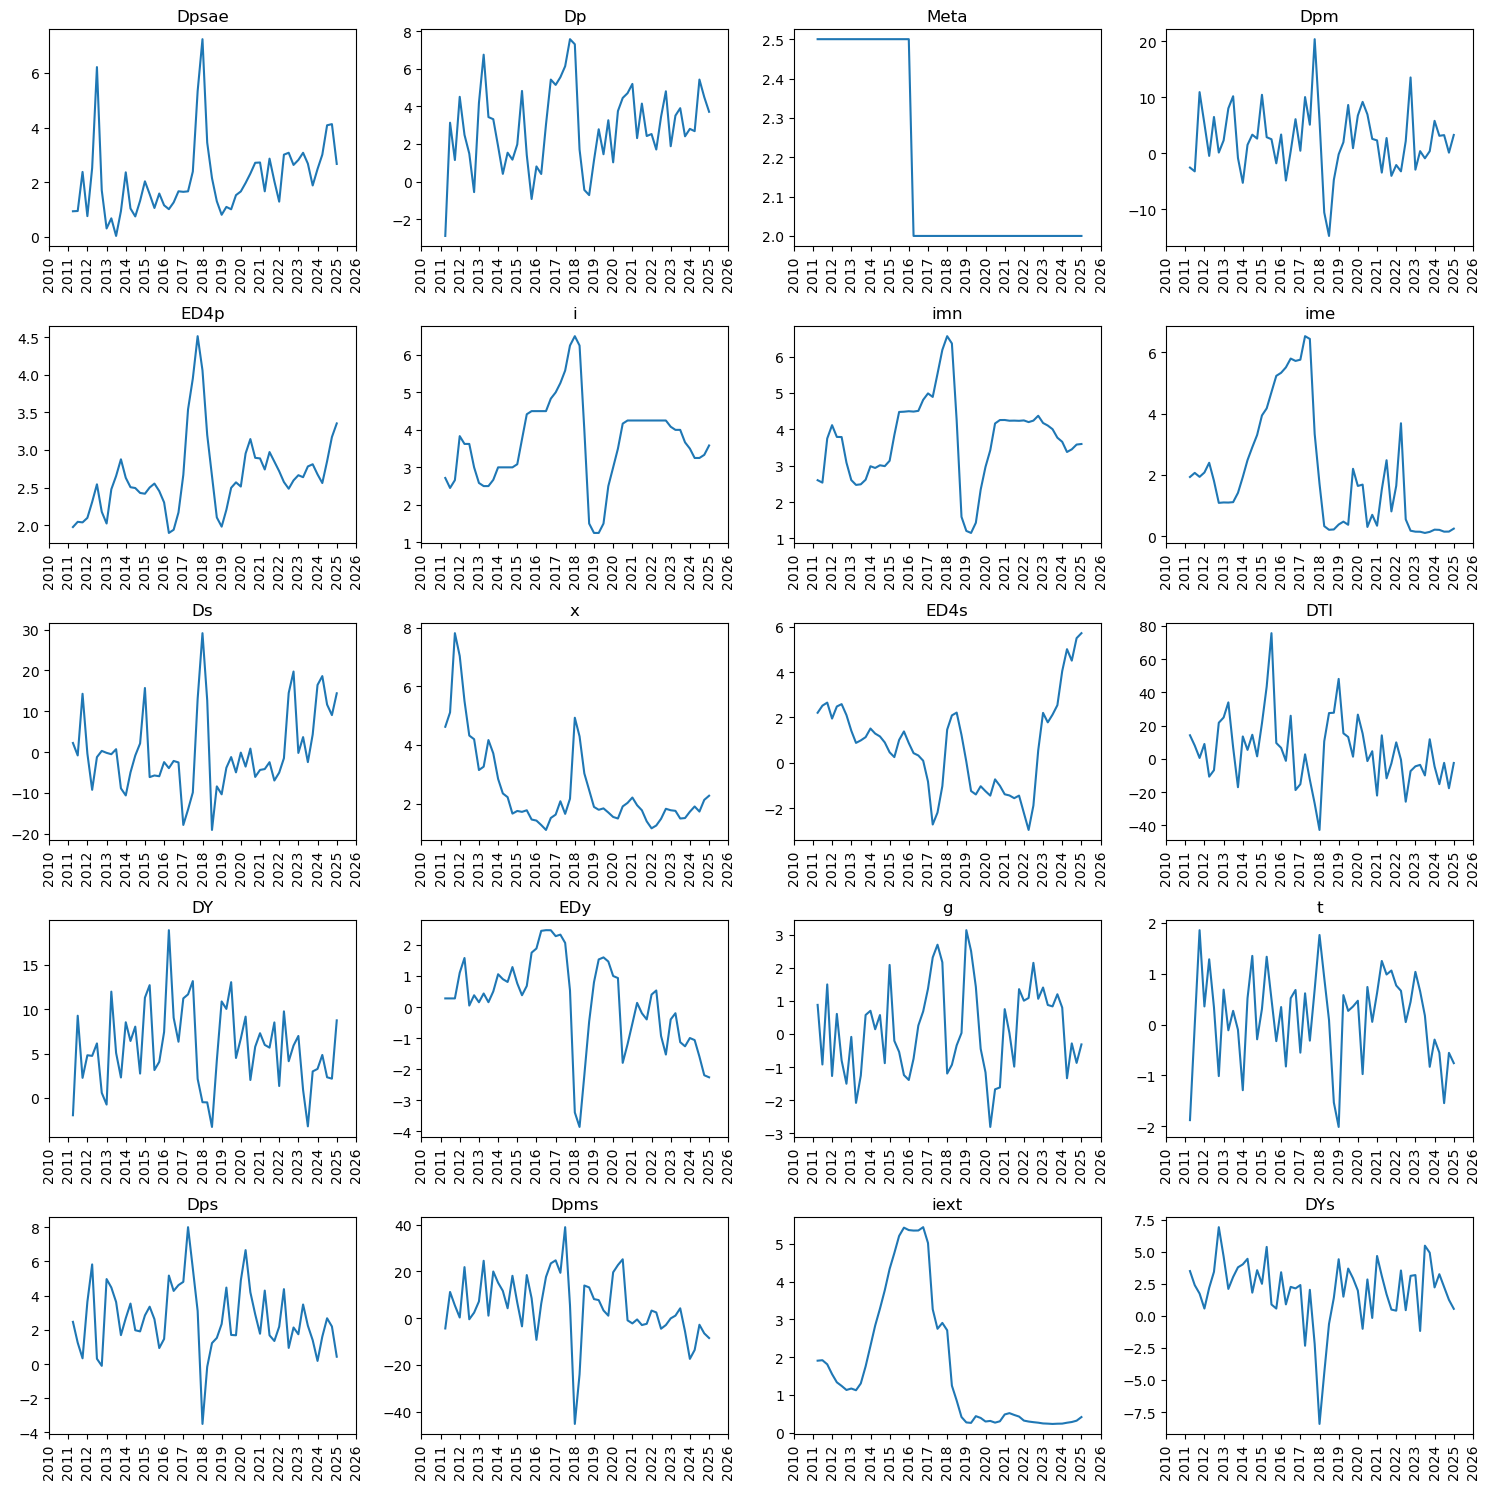

In [11]:
obsnames = DLM.sympy_to_list(Mod['StateSpaceForm']['obs_names'])
num_cols = len(obsnames)
num_rows = math.ceil(num_cols / 4)

fig, axs = plt.subplots(num_rows, 4, figsize=(15, num_rows * 3))


for idx, col in enumerate(obsnames):
    row = idx // 4
    col_idx = idx % 4
    axs[row, col_idx].plot(DBobs.index, DBobs[col], linestyle='-')
    axs[row, col_idx].set_title(col)
    axs[row, col_idx].tick_params(axis='x', rotation = 90)
    axs[row, col_idx].set_xticks(axs[row, col_idx].get_xticks()[::4])

    axs[row, col_idx].xaxis.set_major_locator(mdates.YearLocator())
    axs[row, col_idx].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

for idx in range(num_cols, num_rows * 4):
    fig.delaxes(axs.flatten()[idx])

plt.tight_layout()
plt.show()

In [12]:
DF_s, DF_u, minuslogL = DLM.KFts(DBobs, Mod, {'diffuse':False})

In [13]:
SS = Mod['Solution']['Y0'].reshape(-1,1)


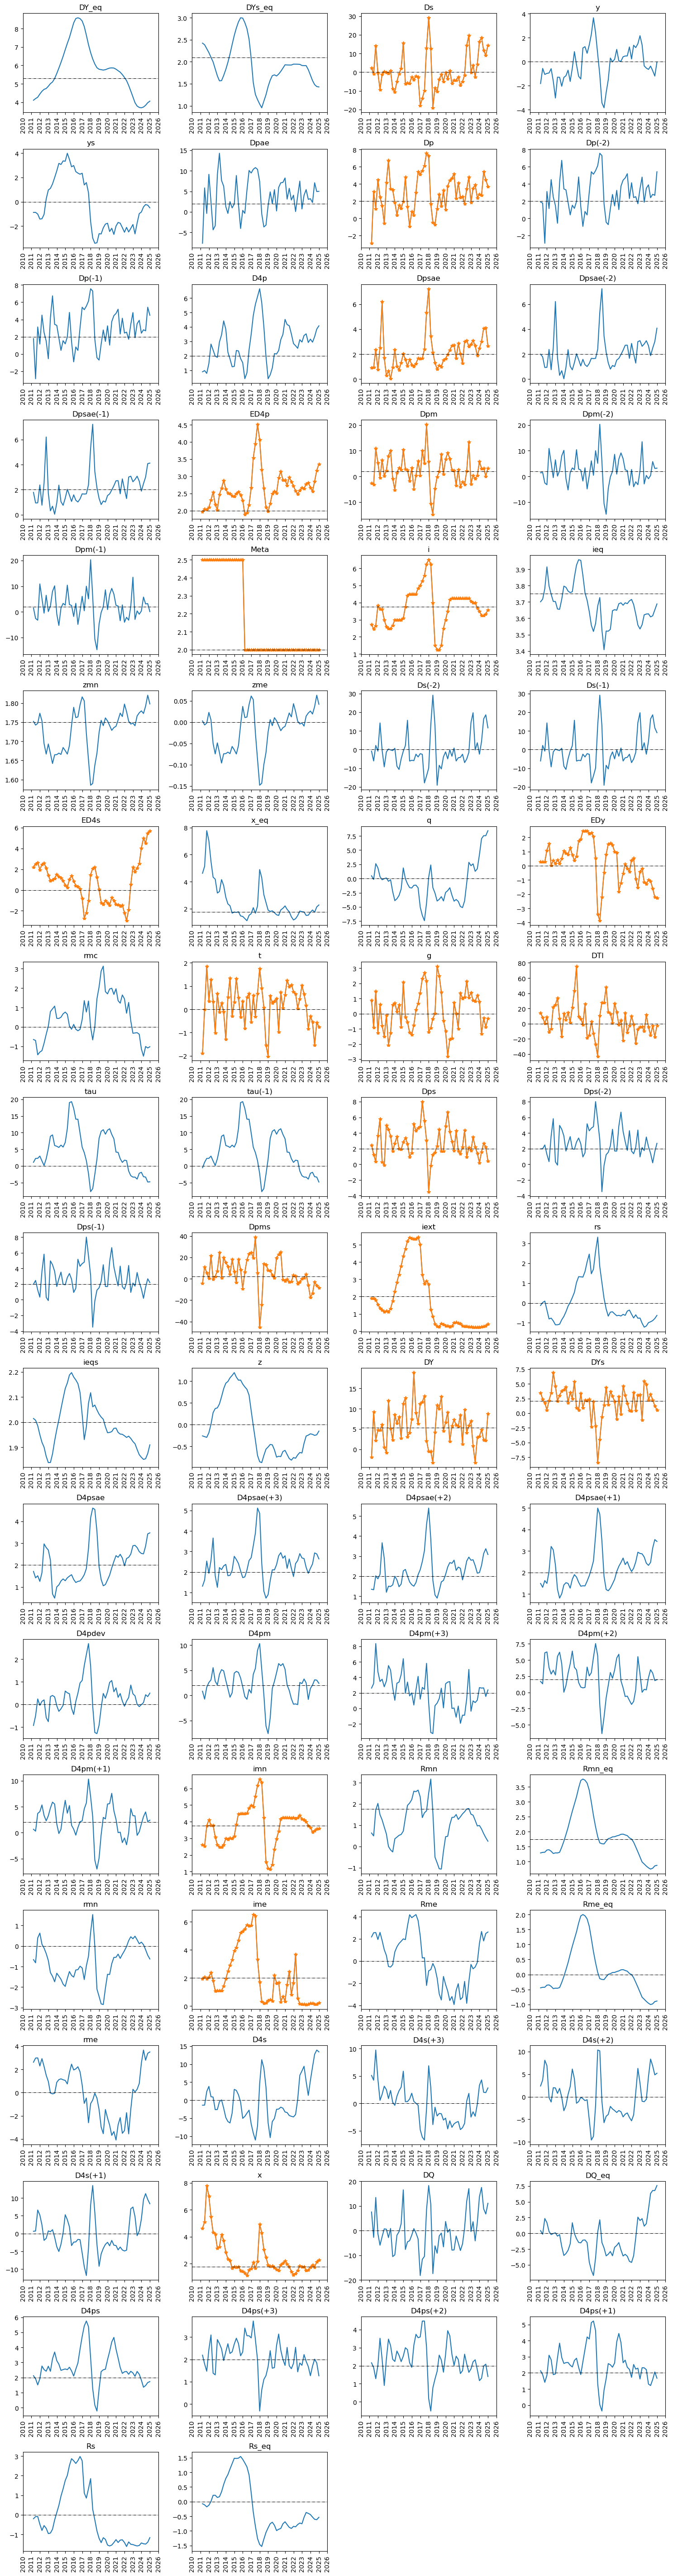

In [14]:
columns = DF_s.columns
num_cols = len(columns)
num_rows = math.ceil(num_cols / 4)

fig, axs = plt.subplots(num_rows, 4, figsize=(15, num_rows * 3))


for idx, col in enumerate(columns):
    row = idx // 4
    col_idx = idx % 4
    axs[row, col_idx].plot(DF_s.index, DF_s[col], linestyle='-')
    axs[row, col_idx].set_title(col)
    observable = False
    for obs in obsnames:
        if col == obs:
            observable = True
    if observable:
        axs[row, col_idx].plot(DF_s.index, DBobs[col], linestyle='-',marker='*')
    axs[row, col_idx].tick_params(axis='x', rotation = 90)
    axs[row, col_idx].set_xticks(axs[row, col_idx].get_xticks()[::4])

    axs[row, col_idx].axhline(y=SS[idx], color='black', linestyle='-.', linewidth=0.75)

    axs[row, col_idx].xaxis.set_major_locator(mdates.YearLocator())
    axs[row, col_idx].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

for idx in range(num_cols, num_rows * 4):
    fig.delaxes(axs.flatten()[idx])

plt.tight_layout()
plt.show()

In [15]:
Data = DF_s

# Forecast

1. Unconditional

In [16]:
FH = 8
FDB = DLM.DSGEforecast0(Mod,Data,FH,'2025Q1')

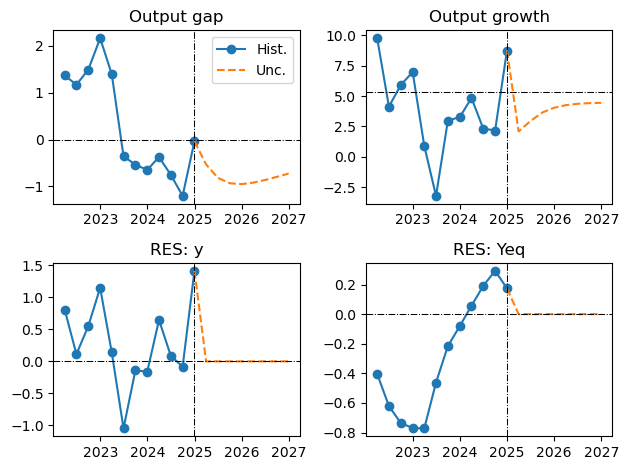

In [17]:
DBdict = {'Unc.': FDB}
lista = ['y','DY','res_y','res_DY_eq']
listanames = ['Output gap','Output growth','RES: y','RES: Yeq']
listaSS = [0,5.3,0,0]
HH = 12
Number_Rows = 2
Number_Cols = 2
fig, axs = HTS.plotTSforecast(DBdict,lista,listanames,listaSS,FH,HH,Number_Rows,Number_Cols)

BORRAR LUEGO

In [18]:
FDB_report_endog = FDB.loc[FDB.index[-(FH+4):]][var] \
                      .round(2) 

FDB_report_exog = FDB.loc[FDB.index[-(FH+4):]][varexo] \
                      .round(2) 

FDB_report_endog.index = FDB_report_endog.index.to_period('Q').strftime('%Y-Q%q')
FDB_report_exog.index = FDB_report_exog.index.to_period('Q').strftime('%Y-Q%q')

FDB_report_endog_pdf = FDB_report_endog.T
FDB_report_exog_pdf = FDB_report_exog.T

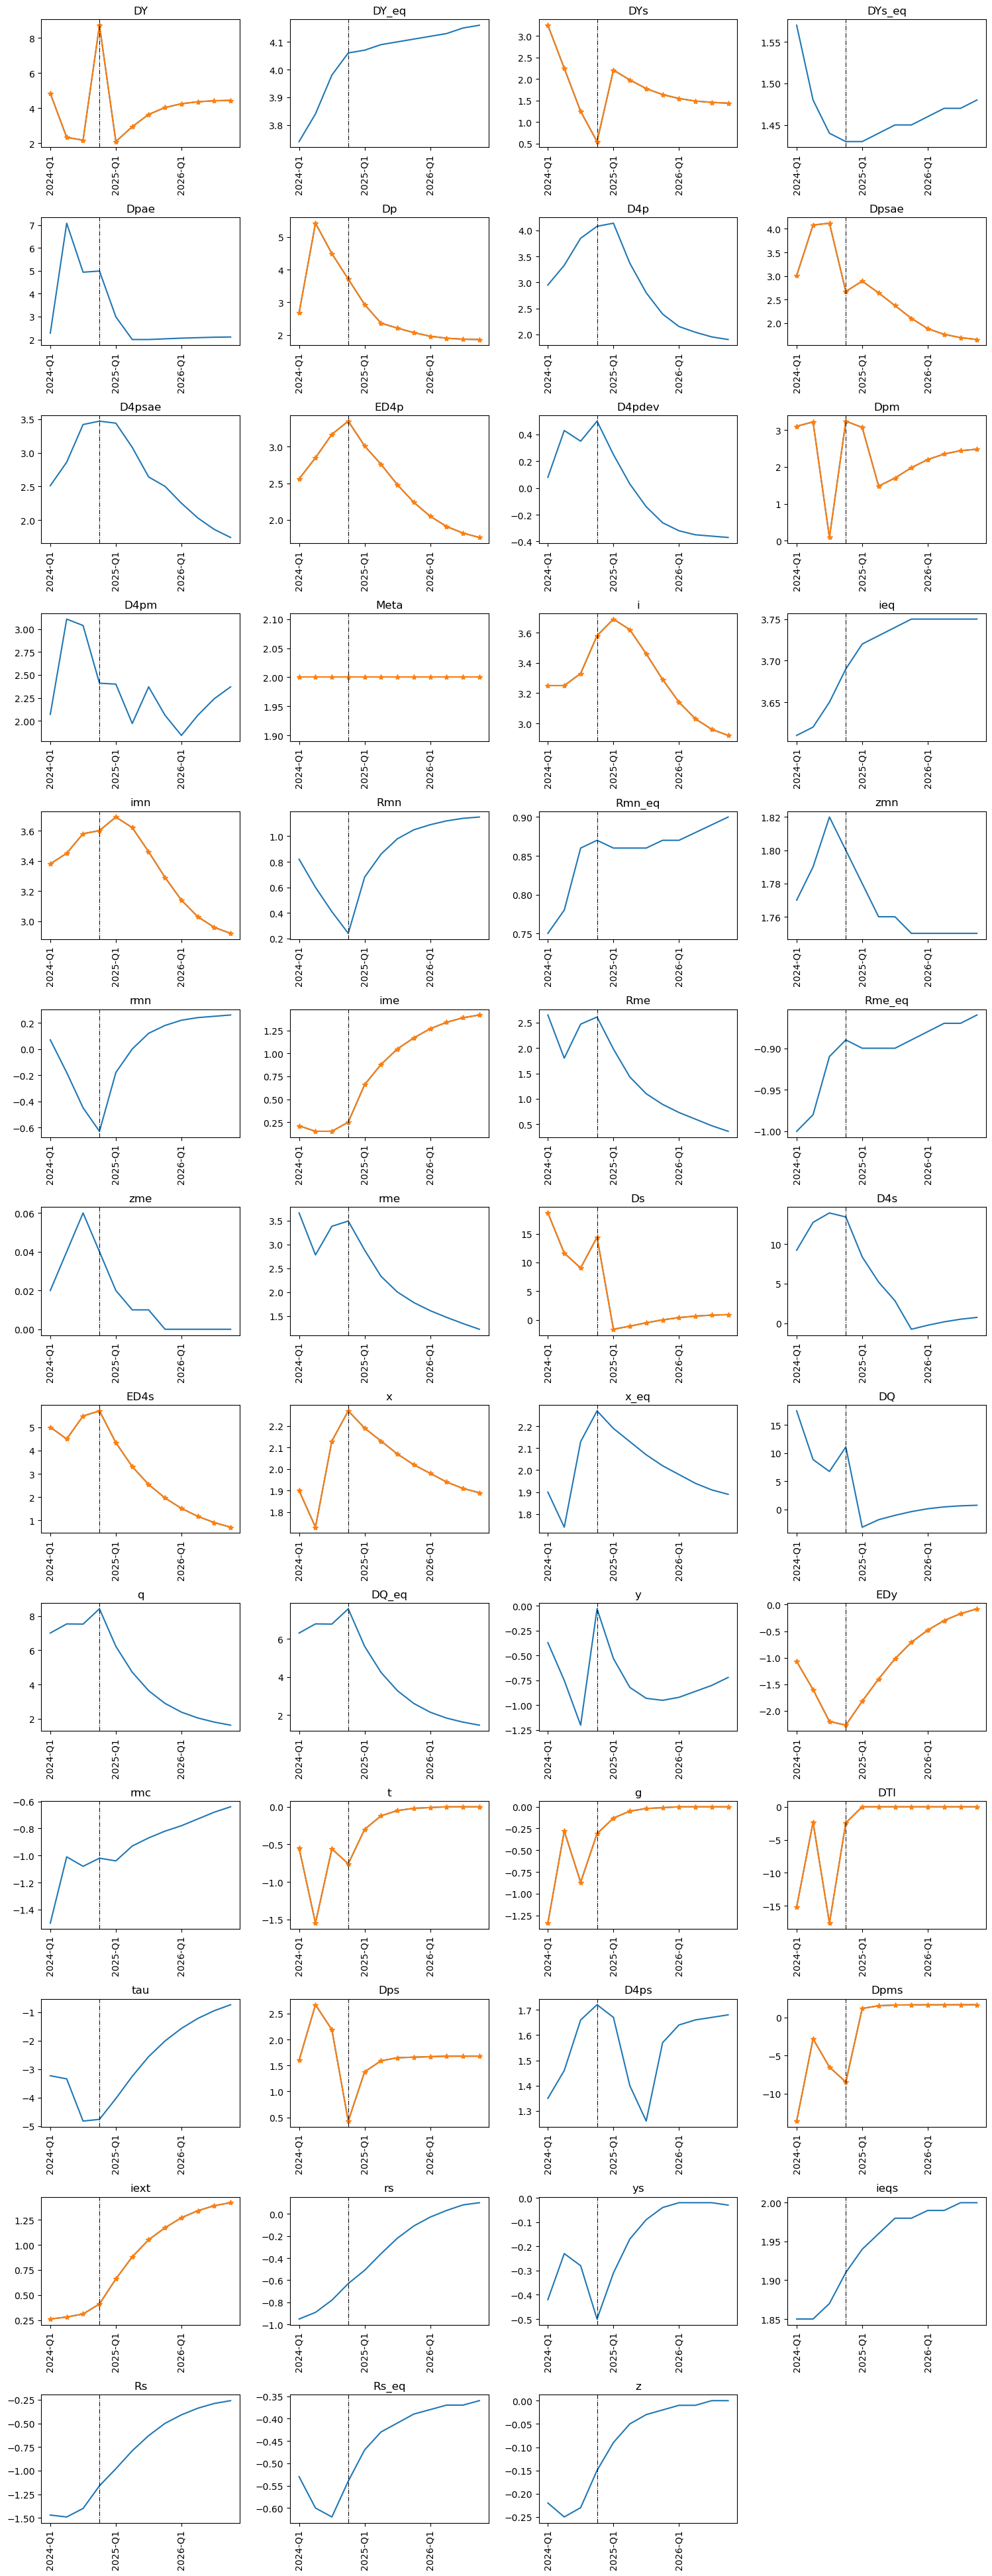

In [19]:
columns = FDB_report_endog.columns
num_cols = len(columns)
num_rows = math.ceil(num_cols / 4)

fig, axs = plt.subplots(num_rows, 4, figsize=(15, num_rows * 3))


for idx, col in enumerate(columns):
    row = idx // 4
    col_idx = idx % 4
    axs[row, col_idx].plot(FDB_report_endog.index, FDB_report_endog[col], linestyle='-')
    axs[row, col_idx].set_title(col)
    observable = False
    for obs in obsnames:
        if col == obs:
            observable = True
    if observable:
        axs[row, col_idx].plot(FDB_report_endog.index, FDB_report_endog[col], linestyle='-',marker='*')
    axs[row, col_idx].tick_params(axis='x', rotation = 90)
    xticks = axs[row, col_idx].get_xticks()
    axs[row, col_idx].set_xticks(xticks[::4])

    if len(xticks) > 3:
        axs[row, col_idx].axvline(x=xticks[3], color='black', linestyle='-.', linewidth=0.75)


    #axs[row, col_idx].xaxis.set_major_locator(mdates.YearLocator())
    #axs[row, col_idx].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))


for idx in range(num_cols, num_rows * 4):
    fig.delaxes(axs.flatten()[idx])

plt.tight_layout()
plt.show()

In [20]:
pdf_file = "FDB_report.pdf"
current_datetime = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

with PdfPages(pdf_file) as pdf:
    # First page for FDB_report_endog
    fig, ax = plt.subplots(figsize=(8.5, 11))
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.set_frame_on(False)

    table = ax.table(cellText=FDB_report_endog_pdf.values,
                     colLabels=FDB_report_endog_pdf.columns,
                     rowLabels=FDB_report_endog_pdf.index,
                     cellLoc='center',
                     loc='center')

    fig.text(0.01, 0.99, f'Fecha de reporte: {current_datetime}', fontsize=10, verticalalignment='top', horizontalalignment='left', bbox=dict(facecolor='white', alpha=0.5))

    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2)

    adjust_column_widths(table, ax)

    fig.tight_layout(pad=3.0)
    pdf.savefig(fig, bbox_inches='tight')
    plt.close(fig)

    # Second page for FDB_report_exog
    fig_exog, ax_exog = plt.subplots(figsize=(8.5, 11))
    ax_exog.xaxis.set_visible(False)
    ax_exog.yaxis.set_visible(False)
    ax_exog.set_frame_on(False)

    table_exog = ax_exog.table(cellText=FDB_report_exog.values,
                               colLabels=FDB_report_exog.columns,
                               rowLabels=FDB_report_exog.index,
                               cellLoc='center',
                               loc='center')

    fig_exog.text(0.01, 0.99, f'Fecha de reporte: {current_datetime}', fontsize=10, verticalalignment='top', horizontalalignment='left', bbox=dict(facecolor='white', alpha=0.5))

    table_exog.auto_set_font_size(False)
    table_exog.set_fontsize(10)
    table_exog.scale(1.2, 1.2)

    adjust_column_widths(table_exog, ax_exog)

    fig_exog.tight_layout(pad=3.0)
    pdf.savefig(fig_exog, bbox_inches='tight')
    plt.close(fig_exog)

print(f"'{pdf_file}' created successfully.")

C:\Users\2663\AppData\Local\Temp\ipykernel_9440\3850568525.py:49: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig_exog.tight_layout(pad=3.0)


'FDB_report.pdf' created successfully.


2. Not anticipated conditional forecast

In [90]:
UCond = HTS.ReadForeCond('Riesgo/DataTarea_Exogenas_Riesgo6.xlsx','2025Q1', FH)

In [91]:
print('Which are the assumptions?')
print('Unanticipated Softtunning')
print(UCond['UShock'])
print('Unanticipated Hardtunning')
print(UCond['Uvar']['var'])
print('-> Shocks to achieve hardtunning:')
print(UCond['Uvar']['shock'])

Which are the assumptions?
Unanticipated Softtunning
            res_Dps  res_ys
2025-03-31      NaN     NaN
2025-06-30      NaN     NaN
2025-09-30      NaN     NaN
2025-12-31      NaN     NaN
2026-03-31      NaN     NaN
2026-06-30      NaN     NaN
2026-09-30      NaN     NaN
2026-12-31      NaN     NaN
Unanticipated Hardtunning
                  ys  DTI       EDy   i
2025-03-31 -0.205134  5.5 -1.324277 NaN
2025-06-30 -0.121549  5.5 -0.900112 NaN
2025-09-30 -0.038265  5.5 -0.522360 NaN
2025-12-31  0.020000  4.0 -0.213991 NaN
2026-03-31  0.050000  4.0  0.024880 NaN
2026-06-30  0.050000  2.5  0.203331 NaN
2026-09-30  0.050000  2.5  0.332963 NaN
2026-12-31  0.050000  2.5  0.424089 NaN
-> Shocks to achieve hardtunning:
['res_ys', 'res_DTI', 'res_EDy', 'res_i']


In [92]:
UFDB = DLM.DSGEforecast0(Mod,Data,FH,'2025Q1',UCond)

In [93]:
UFDB_report_endog = UFDB.loc[UFDB.index[-(FH+4):]][var] \
                      .round(2) 

UFDB_report_exog = UFDB.loc[UFDB.index[-(FH+4):]][varexo] \
                      .round(2)

UFDB_report_endog.index = UFDB_report_endog.index.to_period('Q').strftime('%Y-Q%q')
UFDB_report_exog.index = UFDB_report_exog.index.to_period('Q').strftime('%Y-Q%q')

UFDB_report_endog_pdf = UFDB_report_endog.T
UFDB_report_exog_pdf = UFDB_report_exog.T

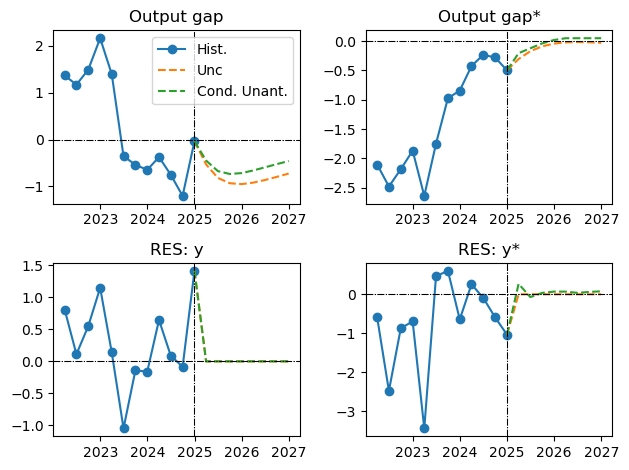

In [94]:
BDdict = {'Unc': FDB,'Cond. Unant.': UFDB}
lista = ['y','ys','res_y','res_ys']
listanames = ['Output gap','Output gap*','RES: y','RES: y*']
listaSS = [0,0,0,0]
HH = 12
Number_Rows = 2
Number_Cols = 2
fig, axs = HTS.plotTSforecast(BDdict,lista,listanames,listaSS,FH,HH,Number_Rows,Number_Cols)

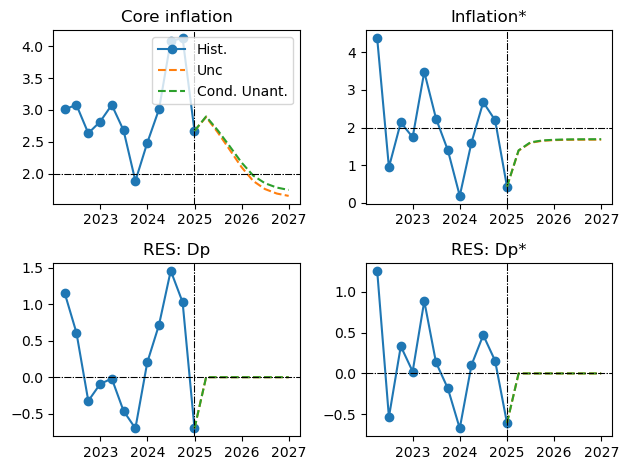

In [95]:
lista = ['Dpsae','Dps','res_Dpsae','res_Dps']
listanames = ['Core inflation','Inflation*','RES: Dp','RES: Dp*']
listaSS = [2,2,0,0]
fig, axs = HTS.plotTSforecast(BDdict,lista,listanames,listaSS,FH,HH,Number_Rows,Number_Cols)

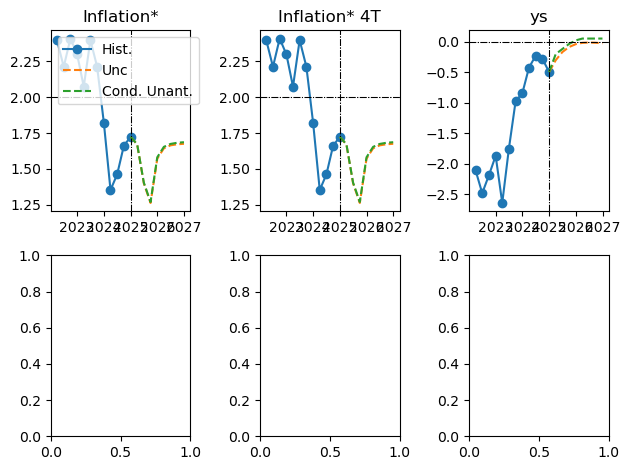

In [96]:
# Dps = bsp*Dps(-1) + (1 - bsp)*D4ps(+4) + bsy*ys(-1) + res_Dps
lista   = ['D4ps','D4ps','ys']
listaSS = [2,2,0]
listanames = ['Inflation*','Inflation* 4T','ys']

fig, axs = HTS.plotTSforecast(BDdict,lista,listanames,listaSS,FH,HH,2,3)

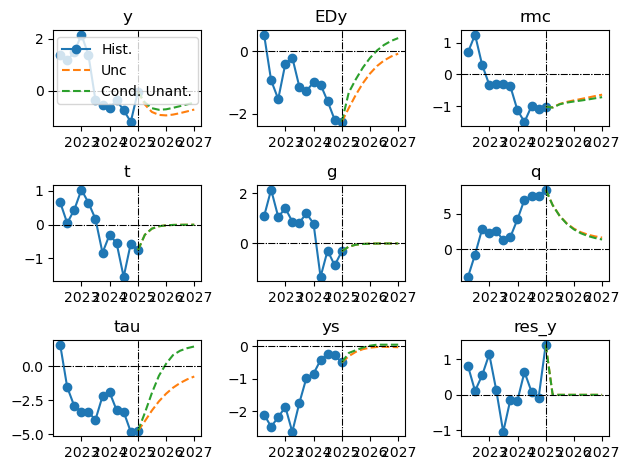

In [97]:
#y = ay*y(-1) + aEy*(y(-1) + EDy) + armc*rmc(-1) - at*t + ag*g + aq*q + atau*tau+ ays*ys + m_res_y*res_y
lista   = ['y','EDy','rmc','t','g','q','tau','ys','res_y']
listaSS = [0,0,0,0,0,0,0,0,0]
listanames = lista

fig, axs = HTS.plotTSforecast(BDdict,lista,listanames,listaSS,FH,HH,3,3)

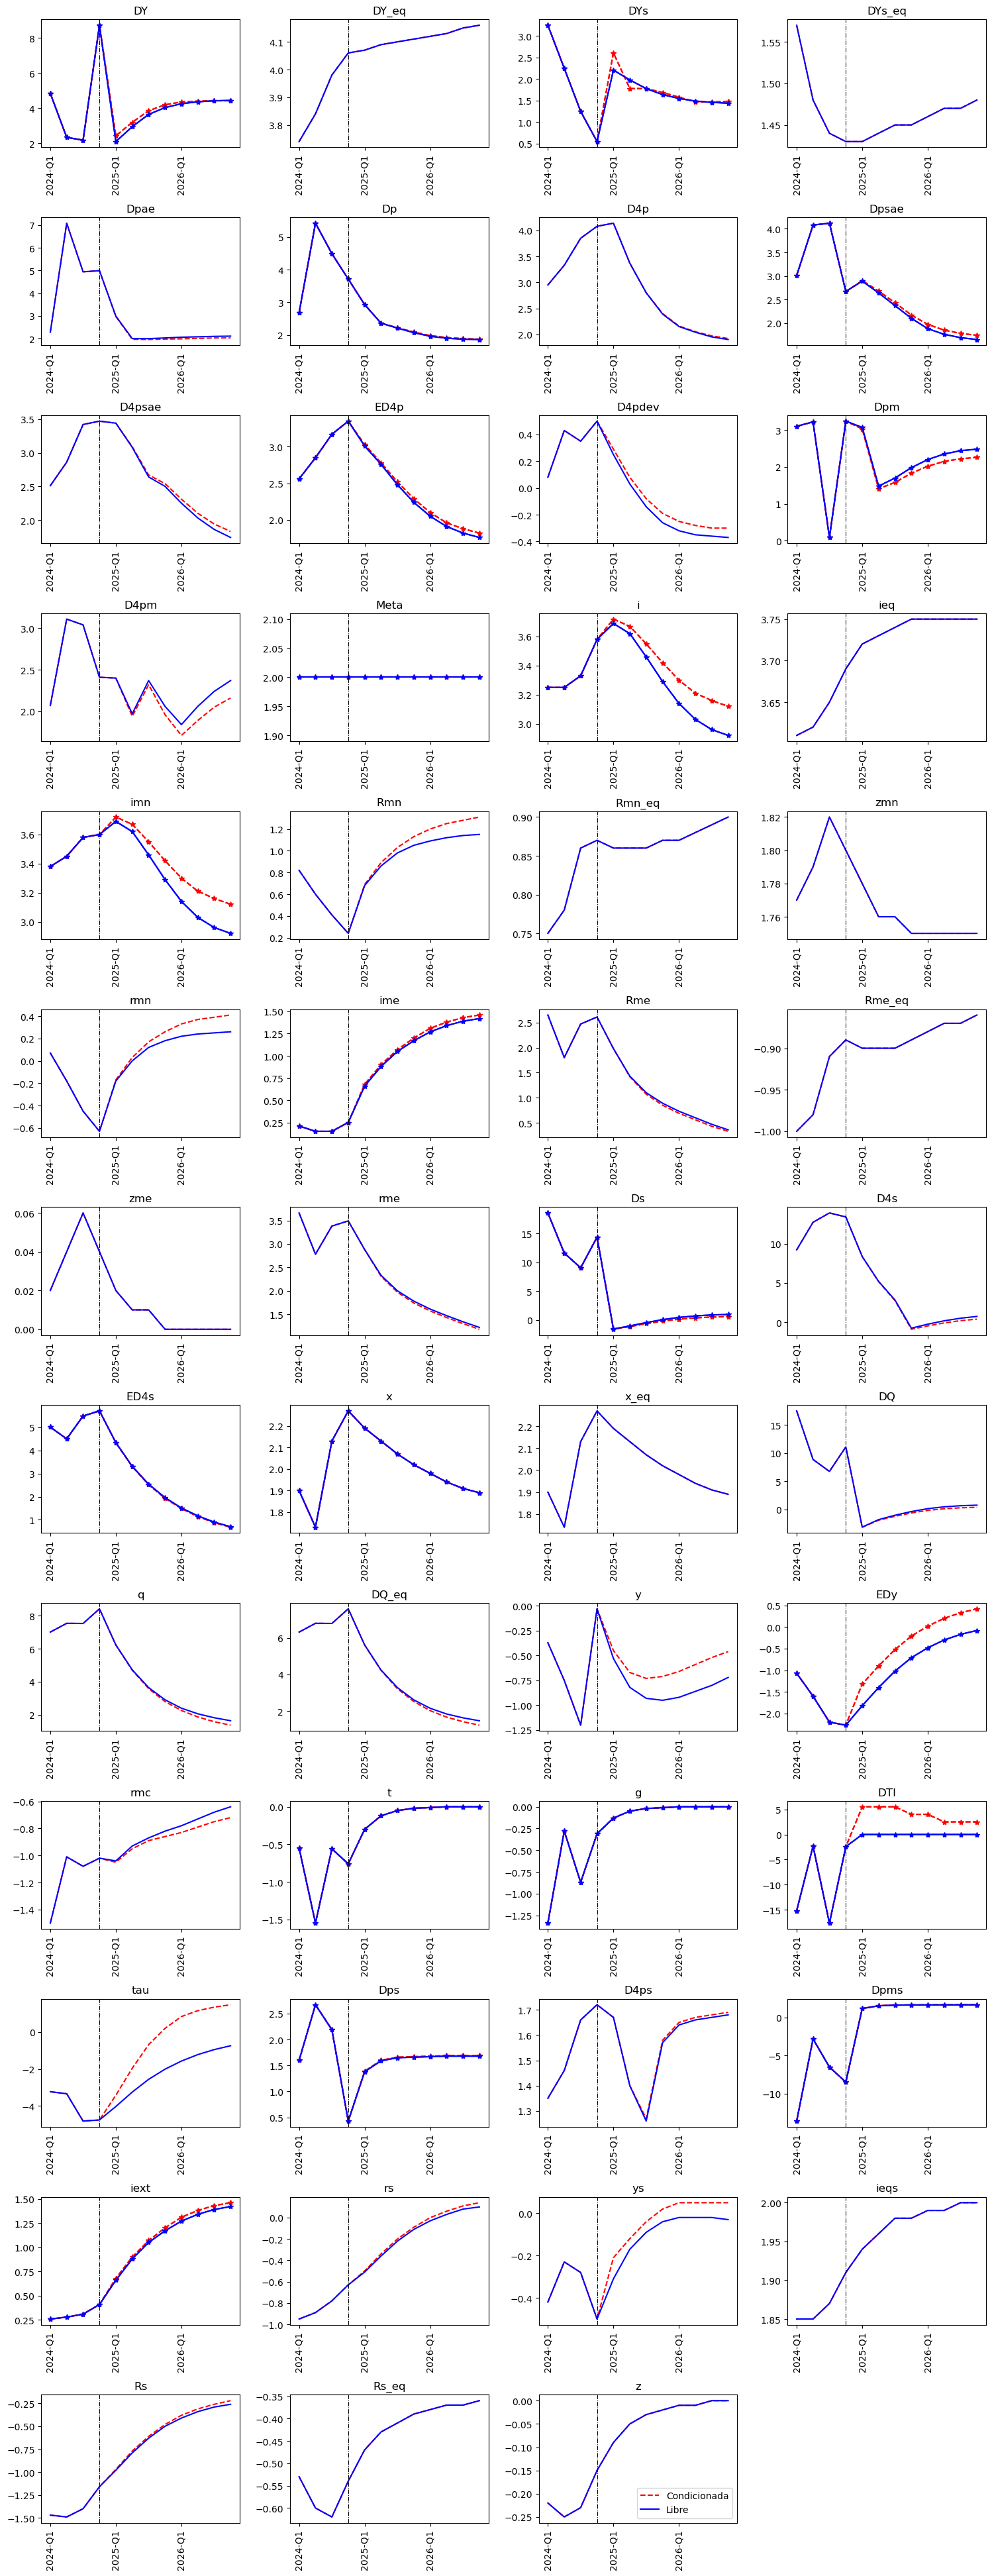

In [98]:
columns = UFDB_report_endog.columns
num_cols = len(columns)
num_rows = math.ceil(num_cols / 4)

fig, axs = plt.subplots(num_rows, 4, figsize=(15, num_rows * 3))

for idx, col in enumerate(columns):
    row = idx // 4
    col_idx = idx % 4
    axs[row, col_idx].plot(UFDB_report_endog.index, UFDB_report_endog[col], linestyle='--', label='Condicionada', color = 'red')
    axs[row, col_idx].plot(FDB_report_endog.index, FDB_report_endog[col], linestyle='-', label='Libre', color = 'blue')
    axs[row, col_idx].set_title(col)
    observable = False
    for obs in obsnames:
        if col == obs:
            observable = True
    if observable:
        axs[row, col_idx].plot(UFDB_report_endog.index, UFDB_report_endog[col], linestyle='--', marker='*', label='Cond. Obs.', color = 'red')
        axs[row, col_idx].plot(FDB_report_endog.index, FDB_report_endog[col], linestyle='-', marker='*', label='Libre', color = 'blue')
    axs[row, col_idx].tick_params(axis='x', rotation=90)
    xticks = axs[row, col_idx].get_xticks()
    axs[row, col_idx].set_xticks(xticks[::4])

    if len(xticks) > 3:
        axs[row, col_idx].axvline(x=xticks[3], color='black', linestyle='-.', linewidth=0.75)

    #axs[row, col_idx].xaxis.set_major_locator(mdates.YearLocator())
    #axs[row, col_idx].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

for idx in range(num_cols, num_rows * 4):
    fig.delaxes(axs.flatten()[idx])

plt.tight_layout()
plt.legend()
plt.show()

In [71]:
pdf_file = "UFDB_report.pdf"
current_datetime = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

with PdfPages(pdf_file) as pdf:
    # First page for FDB_report_endog
    fig, ax = plt.subplots(figsize=(8.5, 11))
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.set_frame_on(False)

    table = ax.table(cellText=UFDB_report_endog_pdf.values,
                     colLabels=UFDB_report_endog_pdf.columns,
                     rowLabels=UFDB_report_endog_pdf.index,
                     cellLoc='center',
                     loc='center')

    fig.text(0.01, 0.99, f'Fecha de reporte: {current_datetime}', fontsize=10, verticalalignment='top', horizontalalignment='left', bbox=dict(facecolor='white', alpha=0.5))

    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2)

    adjust_column_widths(table, ax)

    fig.tight_layout(pad=3.0)
    pdf.savefig(fig, bbox_inches='tight')
    plt.close(fig)

    # Second page for FDB_report_exog
    fig_exog, ax_exog = plt.subplots(figsize=(8.5, 11))
    ax_exog.xaxis.set_visible(False)
    ax_exog.yaxis.set_visible(False)
    ax_exog.set_frame_on(False)

    table_exog = ax_exog.table(cellText=UFDB_report_exog_pdf.values,
                               colLabels=UFDB_report_exog_pdf.columns,
                               rowLabels=UFDB_report_exog_pdf.index,
                               cellLoc='center',
                               loc='center')

    fig_exog.text(0.01, 0.99, f'Fecha de reporte: {current_datetime}', fontsize=10, verticalalignment='top', horizontalalignment='left', bbox=dict(facecolor='white', alpha=0.5))

    table_exog.auto_set_font_size(False)
    table_exog.set_fontsize(10)
    table_exog.scale(1.2, 1.2)

    adjust_column_widths(table_exog, ax_exog)

    fig_exog.tight_layout(pad=3.0)
    pdf.savefig(fig_exog, bbox_inches='tight')
    plt.close(fig_exog)

print(f"'{pdf_file}' created successfully.")

'UFDB_report.pdf' created successfully.


* Intento de reporteador

Aquí se ve que la confianza ```EDy``` y las condicniones monetarias ```rmc``` explican principalmente la brecha

In [31]:
# Intento de reporteador
#y = ay*y(-1) + aEy*(y(-1) + EDy) + armc*rmc(-1) - at*t + ag*g + aq*q + atau*tau+ ays*ys + m_res_y*res_y

ay = 0.539500000000000
aEy = 0.127700000000000
armc = 0.300000000000000
at = 0.005000000000000
ag = 0.115200000000000
ays = 0.055100000000000
atau = 0.020500000000000
aq = 0.023200000000000
m_res_y = (0.900300000000000)**0.5

hist2show = 4

y     = UFDB['y'].values[-(hist2show+FH):].reshape(-1,1)
yl    = (ay+aEy)*UFDB['y'].values[-((hist2show+FH)+1):-1].reshape(-1,1)
yEDy  = aEy*UFDB['EDy'].values[-(hist2show+FH):].reshape(-1,1)
rmc   = armc*UFDB['rmc'].values[-((hist2show+FH)+1):-1].reshape(-1,1)
t     = -at*UFDB['t'].values[-(hist2show+FH):].reshape(-1,1)
g     = ag*UFDB['g'].values[-(hist2show+FH):].reshape(-1,1)
q     = aq*UFDB['q'].values[-(hist2show+FH):].reshape(-1,1)
tau   = atau*UFDB['tau'].values[-(hist2show+FH):].reshape(-1,1)
ys    = ays*UFDB['ys'].values[-(hist2show+FH):].reshape(-1,1)
res_y = m_res_y*UFDB['res_y'].values[-(hist2show+FH):].reshape(-1,1)
pd.DataFrame(np.c_[y,yl,yEDy,rmc,t,g,q,tau,ys,res_y], columns=['y','(ay+aEy)*y(-1)','aEy*EDy','armc*rmc(-1)','-at*t','ag*g','aq*q','atau*tau','ays*ys','m_res_y*res_y'], index=UFDB.index[-(hist2show+FH):]).T

,2024-03-31,2024-06-30,2024-09-30,2024-12-31,2025-03-31,2025-06-30,2025-09-30,2025-12-31,2026-03-31,2026-06-30,2026-09-30,2026-12-31
y,-0.372058,-0.749937,-1.201698,-0.034537,0.020260,-0.078851,-0.132774,-0.168151,-0.194377,-0.210665,-0.215105,-0.207873
(ay+aEy)*y(-1),-0.430945,-0.248237,-0.500358,-0.801773,-0.023043,0.013518,-0.052609,-0.088587,-0.112190,-0.129688,-0.140556,-0.143518
aEy*EDy,-0.136213,-0.204320,-0.280940,-0.289453,0.317662,0.191313,0.191621,0.195975,0.199063,0.202401,0.204803,0.205879
armc*rmc(-1),-0.339501,-0.451219,-0.301934,-0.324542,-0.305547,-0.307740,-0.288070,-0.285037,-0.285519,-0.283876,-0.277293,-0.266548
-at*t,0.002764,0.007736,0.002787,0.003799,0.001490,0.000585,0.000229,0.000090,0.000035,0.000014,0.000005,0.000002
ag*g,-0.153978,-0.032631,-0.100608,-0.036271,-0.014552,-0.005838,-0.002342,-0.000940,-0.000377,-0.000151,-0.000061,-0.000024
aq*q,0.162716,0.174880,0.174753,0.195245,0.143760,0.105375,0.075832,0.053794,0.037820,0.026447,0.018485,0.012995
atau*tau,-0.066133,-0.068470,-0.098857,-0.097495,-0.082698,-0.066610,-0.052571,-0.041143,-0.032085,-0.024983,-0.019441,-0.015124
ays*ys,-0.023415,-0.012813,-0.015377,-0.027463,-0.016813,-0.009452,-0.004863,-0.002303,-0.001124,-0.000827,-0.001048,-0.001535
m_res_y*res_y,0.612646,0.085137,-0.081166,1.343416,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
